In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys; sys.path.insert(0, "../utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df, get_manual_severity_scores
from ml_pipeline import ModelEvaluation, highlight_max

DATA_PATH = get_data_location()

In [7]:
# Path to segmentation masks
SEGMENTATION_PATH = os.path.join(DATA_PATH,"cropped_videos_segmented/post_processing")
# segmentation_path = "/Users/matthiasrichter/Library/CloudStorage/OneDrive-Personal/Studium/Masterthesis/Sample"

# List all files & directories
seg_files = os.listdir(SEGMENTATION_PATH)

# keep only .gif files that end with _mask
seg_mask_files = [x for x in seg_files if x.endswith(".npy")]

print(f"Found {len(seg_mask_files)} segmentation masks")

Found 369 segmentation masks


In [8]:
GIF_PATH = os.path.join(DATA_PATH,"cropped_videos_segmented")
# gif_path = "/Users/matthiasrichter/Library/CloudStorage/OneDrive-Personal/Studium/Masterthesis/Sample"

# List all files & directories
gif_files = os.listdir(GIF_PATH)
# keep only .gif files that end with _processed
gif_files = [x for x in gif_files if x.endswith("_processed.gif")]

print(f"Found {len(gif_files)} processed gifs")

Found 371 processed gifs


In [9]:
FILE_NO = 0

In [10]:
import pandas as pd
# Load gif_files and seg_mask_files into separate pandas dataframes

df_gif_files = pd.DataFrame(gif_files, columns=["file_name_gif"])
df_seg_mask_files = pd.DataFrame(seg_mask_files, columns=["file_name_mask"])

# Split file_name to get patient id
df_gif_files["patient_id"] = df_gif_files["file_name_gif"].apply(lambda x: x.split("_")[0])
df_seg_mask_files["patient_id"] = df_seg_mask_files["file_name_mask"].apply(lambda x: x.split("_")[0])

# Split file_name to get video id
df_gif_files["video_id"] = df_gif_files["file_name_gif"].apply(lambda x: x.split("_")[1:3])
df_gif_files["video_id"] = df_gif_files["video_id"].apply(lambda x: "_".join(x))

df_seg_mask_files["video_id"] = df_seg_mask_files["file_name_mask"].apply(lambda x: x.split("_")[1:3])
df_seg_mask_files["video_id"] = df_seg_mask_files["video_id"].apply(lambda x: "_".join(x))

# Merge dataframes
df_gif_seg_mask = pd.merge(df_gif_files, df_seg_mask_files, on=["patient_id", "video_id"])
# Drop nan values
df_gif_seg_mask = df_gif_seg_mask.dropna()
df_gif_seg_mask.head()


,file_name_gif,patient_id,video_id,file_name_mask
0,A001_image_147549867609700_processed.gif,A001,image_147549867609700,A001_image_147549867609700_processed_mask.gif_...
1,A001_image_147606973438168_processed.gif,A001,image_147606973438168,A001_image_147606973438168_processed_mask.gif_...
2,A001_image_147690538547824_processed.gif,A001,image_147690538547824,A001_image_147690538547824_processed_mask.gif_...
3,A001_image_147763479101025_processed.gif,A001,image_147763479101025,A001_image_147763479101025_processed_mask.gif_...
4,A001_image_147814256633037_processed.gif,A001,image_147814256633037,A001_image_147814256633037_processed_mask.gif_...


In [11]:
import numpy as np
from PIL import Image
import pandas as pd

# gif_path = "/Users/matthiasrichter/Library/CloudStorage/OneDrive-Personal/Studium/Masterthesis/Sample/A001_image_147549867609700_processed.gif"


def load_gif(path):
    frame_list = []
    with Image.open(os.path.join(path)) as im:
        im.seek(1)  # skip to the second frame

        try:
            while 1:
                im.seek(im.tell() + 1)
                frame = im.copy()
                # Convert to grayscale
                frame = frame.convert('L')
                frame_list.append(np.array(frame))
        except EOFError:
            pass  # end of sequence
    
    return np.array(frame_list)

# gif_list = load_gif(gif_path)

In [12]:
gif_file_name = df_gif_seg_mask["file_name_gif"].iloc[FILE_NO]
mask_file_name = df_gif_seg_mask["file_name_mask"].iloc[FILE_NO]

# Load the segmentation mask
print("Loading the segmentation mask number {}: {}".format(FILE_NO, mask_file_name))
mask_array = np.load(os.path.join(SEGMENTATION_PATH, mask_file_name))

# Load the gif file
print("Loading the gif file number {}: {}".format(FILE_NO, gif_file_name))
gif_list = load_gif(os.path.join(GIF_PATH, gif_file_name))

Loading the segmentation mask number 0: A001_image_147549867609700_processed_mask.gif_seg_cluster_maps.npy
Loading the gif file number 0: A001_image_147549867609700_processed.gif


In [13]:
n_frames_gif = len(gif_list)
n_frames_mask = len(mask_array)

# Check if the frame number is not equal
if not n_frames_gif == n_frames_mask:
    print(f"Frame number is not equal. Gif has {n_frames_gif} frames and Mask has {n_frames_mask} frames")
    print("CROPPING TO MINIAL NUMBER OF FRAMES!")
    
    # Crop gif_list and mask_array to the same length
    min_frames = min(n_frames_gif, n_frames_mask)

    gif_list = gif_list[:min_frames]
    mask_array = mask_array[:min_frames]

    # Print shape of both arrays after cropping
    print(f"Gif shape: {gif_list.shape}")
    print(f"Mask shape: {mask_array.shape}")

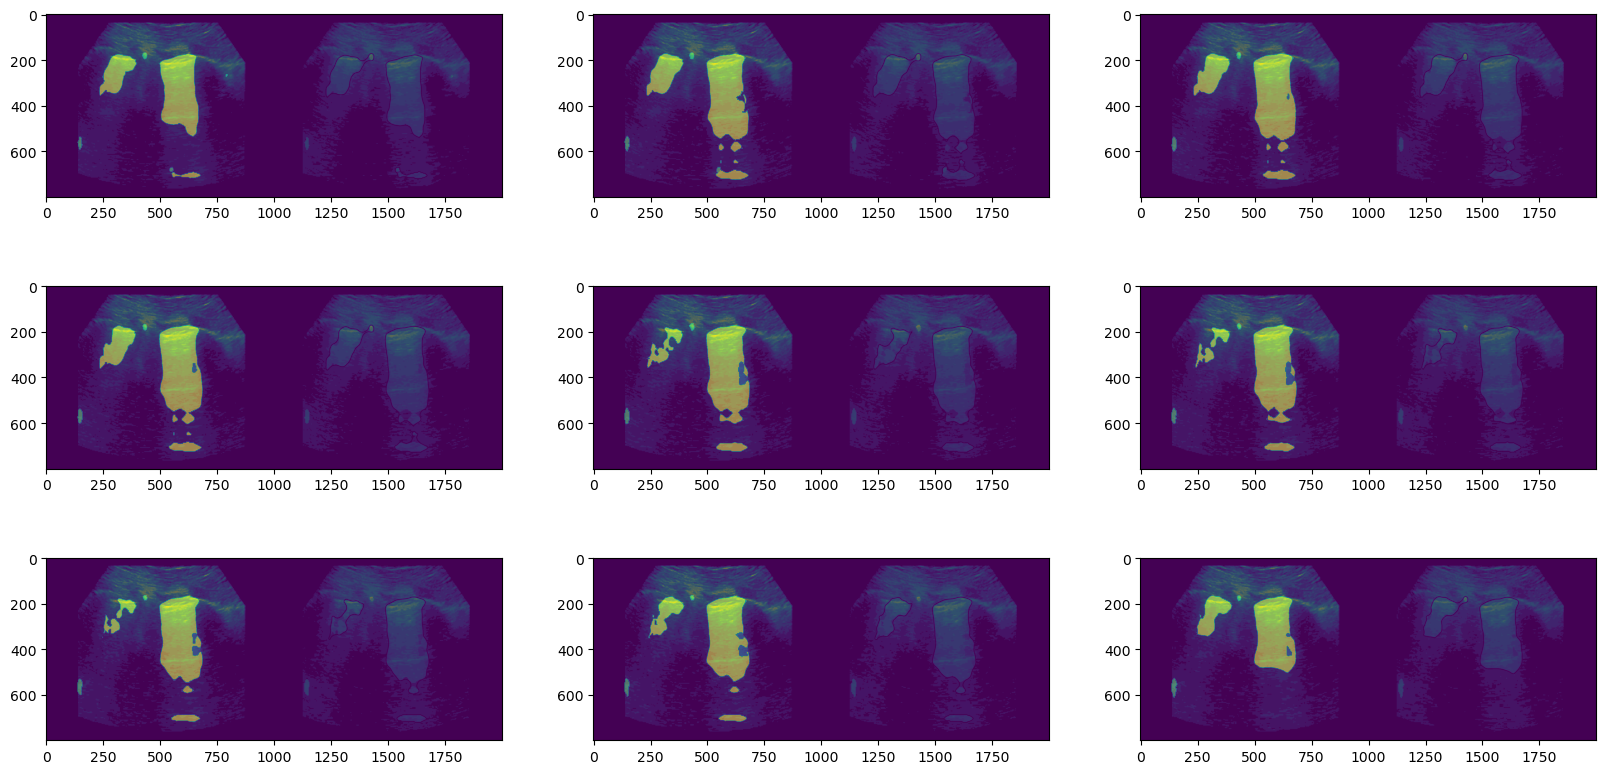

In [14]:
# Plot first 9 frames with mask overlay
fig, ax = plt.subplots(3, 3, figsize=(20, 10))
for i in range(9):
    ax[i // 3, i % 3].imshow(gif_list[i])
    ax[i // 3, i % 3].imshow(np.roll(mask_array[i], -500, axis=1), alpha=0.5)

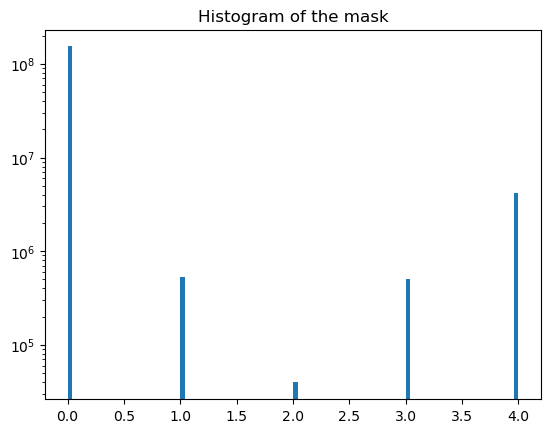

In [15]:
# Histogram of the mask using log scale
plt.hist(mask_array.flatten(), bins=100, log=True)
plt.title("Histogram of the mask")
plt.show()

(800, 1000)
Class 1: 0
Class 2: 0
Class 3: 1462
Class 4: 63550


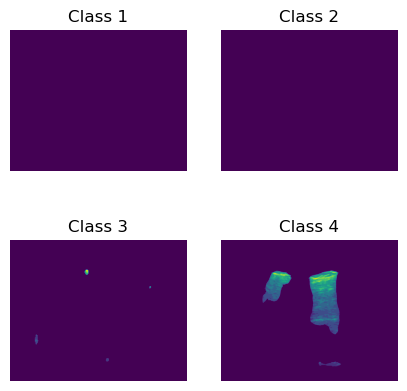

In [16]:
gif = gif_list[0]
mask = mask_array[0]

# Offest mask by 500 pixels to the left to match the unprocessed LUS image
mask = np.roll(mask, -500, axis=1)

# Only take the left half of the gif and the mask
gif = gif[:, :1000]
mask = mask[:, :1000]
print(mask.shape)

classes = [1, 2, 3, 4]
class__filtered_dict = {}
for c in classes:
    print(f"Class {c}: {np.sum(mask == c)}")
    # Set all values in the gif to 0 where the mask is not equal to the class
    class_filtered_gif = gif.copy()
    class_filtered_gif[mask != c] = 0
    class__filtered_dict[c] = class_filtered_gif

# Plot all classes
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
for i, c in enumerate(classes):
    ax = axs[i // 2, i % 2]
    ax.imshow(class__filtered_dict[c])
    ax.set_title(f"Class {c}")
    ax.axis("off")




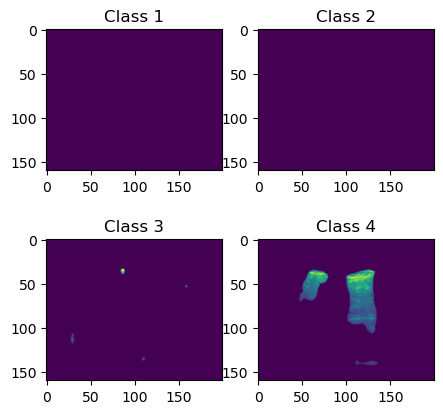

In [17]:
from skimage.transform import resize

# Resize all classes by a factor of 0.1
resize_factor = 5
resized_class__filtered_dict = {}
for c in classes:
    resized_class__filtered_dict[c] = resize(class__filtered_dict[c], 
                                            (class__filtered_dict[c].shape[0] // resize_factor, class__filtered_dict[c].shape[1] // resize_factor), 
                                            anti_aliasing=True)

# Plot all classes
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
for i, c in enumerate(classes):
    ax = axs[i // 2, i % 2]
    ax.imshow(resized_class__filtered_dict[c])
    ax.set_title(f"Class {c}")
    # ax.axis("off")

In [18]:
# Put it all into a pipeline
def filter_frame(frame, mask, resize_factor=10):
    # Offest mask by 500 pixels to the left to match the unprocessed LUS image
    mask = np.roll(mask, -500, axis=1)

    # Only take the left half of the gif and the mask
    frame = frame[:, :1000]
    mask = mask[:, :1000]

    classes = [1, 2, 3, 4]
    class__filtered_dict = {}
    for c in classes:
        # Set all values in the gif to 0 where the mask is not equal to the class
        class_filtered_frame = frame.copy()
        class_filtered_frame[mask != c] = 0
        # Resize by a factor of resize_factor
        class_filtered_frame = resize(class_filtered_frame,
                                    (class_filtered_frame.shape[0] // resize_factor, class_filtered_frame.shape[1] // resize_factor),
                                    anti_aliasing=True)
        class__filtered_dict[c] = class_filtered_frame

    return class__filtered_dict


In [19]:
# Filter all frames
filtered_frames = []
for i in range(len(gif_list)):
    filtered_frames.append(filter_frame(gif_list[i], mask_array[i], resize_factor=50))

# Stack all frames of the filtered & resized classes into a single array
stacked_filtered_frames = {}
for c in classes:
    stacked_filtered_frames[c] = np.stack([x[c] for x in filtered_frames])

In [20]:
def trim_zeros(arr):
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    https://stackoverflow.com/questions/55917328/numpy-trim-zeros-in-2d-or-3d
    Extended to check for zeros arrays
    """
    if np.count_nonzero(arr) == 0:
        return np.zeros((1, 1, 1))
        
    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in np.nonzero(arr))
    return arr[slices]

# Trim all volumes
trimmed_filtered_frames = {}
for c in classes:
    trimmed_filtered_frames[c] = trim_zeros(stacked_filtered_frames[c])

In [21]:
for c in classes:
    print(f"Class {c}: {trimmed_filtered_frames[c].shape}")

Class 1: (97, 10, 8)
Class 2: (71, 14, 7)
Class 3: (99, 15, 17)
Class 4: (99, 15, 13)


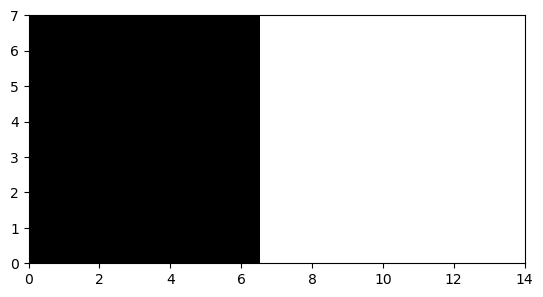

In [22]:
# Animated fly through of the cropped volumes
from matplotlib import animation, rc
from IPython.display import HTML

def animate_volume(volume):
    fig = plt.figure()
    ax = plt.axes(xlim=(0, volume.shape[1]), ylim=(0, volume.shape[2]))
    im = ax.imshow(volume[0], cmap="gray")
    def animate(i):
        im.set_array(volume[i])
        return [im]
    anim = animation.FuncAnimation(fig, animate, frames=volume.shape[0], interval=50, blit=True)
    return anim

# Animate the 4th class
anim = animate_volume(trimmed_filtered_frames[2])
HTML(anim.to_html5_video())

<Figure size 640x480 with 0 Axes>

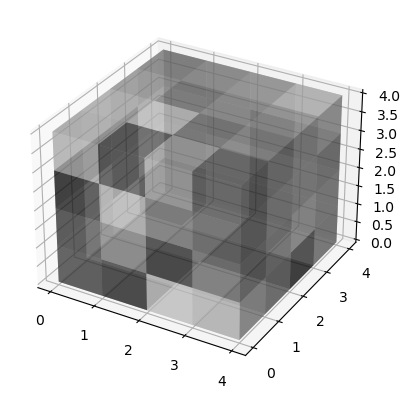

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example of how to plot a 3D volume
N = 4
volume = np.random.rand(N, N, N)
filled = np.ones((N, N, N))

# repeating values 3 times for grayscale
colors = np.repeat(volume[:, :, :, np.newaxis], 3, axis=3)
# Add alpha channel with alpha=0.5
colors = np.concatenate((colors, 0.5 * np.ones((N, N, N, 1))), axis=3)

fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')

ax.voxels(filled, facecolors=colors, edgecolors=None)
plt.show()

In [31]:
# Apply example to the 4th class

volume = trimmed_filtered_frames[4]
# Scale volume to [0, 1]
volume = (volume - volume.min()) / (volume.max() - volume.min())

# Filled is a volume containing ones where the volume is not zero
filled = np.ones(volume.shape)
filled[volume <= 0.1] = 0

# repeating values 3 times for grayscale
colors = np.repeat(volume[:, :, :, np.newaxis], 3, axis=3)
# Scale colors to [0.5, 1]
# colors = (colors - colors.min()) / (colors.max() - colors.min())


(array([4.5246e+04, 1.4310e+03, 9.6600e+02, 5.6700e+02, 5.0400e+02,
        3.9000e+02, 3.8700e+02, 3.3300e+02, 2.9700e+02, 2.1600e+02,
        2.4900e+02, 2.6700e+02, 1.9800e+02, 1.8000e+02, 2.1000e+02,
        1.8000e+02, 1.1100e+02, 2.3700e+02, 1.3500e+02, 1.6200e+02,
        1.0800e+02, 8.4000e+01, 1.2300e+02, 1.8300e+02, 9.3000e+01,
        1.1400e+02, 1.0800e+02, 1.1700e+02, 1.2600e+02, 1.1400e+02,
        1.8000e+02, 1.2000e+02, 1.5000e+02, 1.1100e+02, 9.9000e+01,
        1.0500e+02, 1.2600e+02, 1.4100e+02, 1.6800e+02, 1.4400e+02,
        1.5900e+02, 1.2300e+02, 1.3800e+02, 1.4100e+02, 1.1700e+02,
        1.4100e+02, 9.9000e+01, 1.0200e+02, 6.3000e+01, 7.8000e+01,
        6.3000e+01, 4.8000e+01, 6.3000e+01, 4.2000e+01, 3.6000e+01,
        4.8000e+01, 2.7000e+01, 3.0000e+01, 9.0000e+01, 8.7000e+01,
        6.0000e+01, 6.0000e+01, 4.2000e+01, 3.9000e+01, 1.2000e+01,
        2.7000e+01, 3.3000e+01, 1.5000e+01, 3.3000e+01, 4.8000e+01,
        5.7000e+01, 3.6000e+01, 5.4000e+01, 6.00

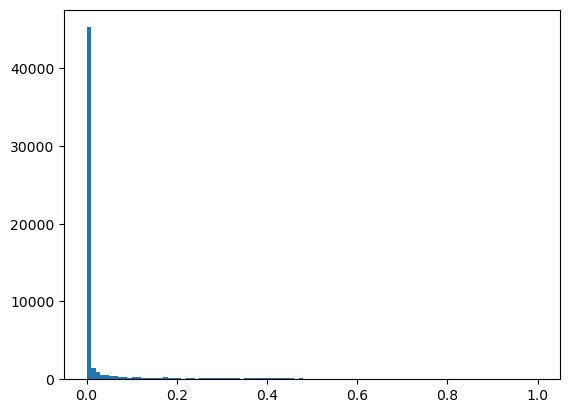

In [32]:
# Histogram of the colors
plt.hist(colors.flatten(), bins=100)

<Figure size 1500x1500 with 0 Axes>

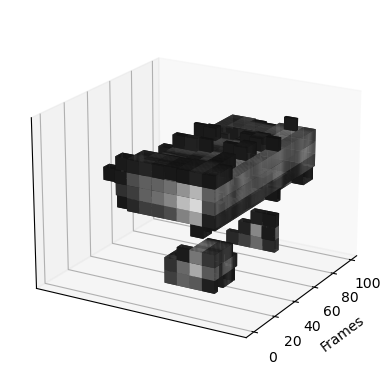

In [51]:

# Add alpha channel with alpha=0.5
# colors = np.concatenate((colors, 0.5 * np.ones((volume.shape[0], volume.shape[1], volume.shape[2], 1))), axis=3)


fig = plt.figure(figsize=(15, 15))
ax = plt.figure().add_subplot(projection='3d')

ax.voxels(filled, facecolors=colors, edgecolors=None)
# Remove the x and y ticks
# ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# Name x axis 
ax.set_xlabel("Frames")

# Roate the plot 90 around the z axis
ax.view_init(20, 210)

plt.show()

<Figure size 1500x1500 with 0 Axes>

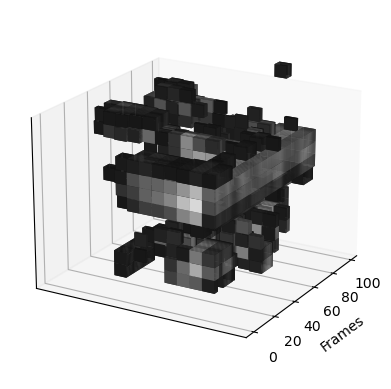

In [70]:
# Plot all four classes in a single plot
fig = plt.figure(figsize=(15, 15))
ax = plt.figure().add_subplot(projection='3d')

for c in classes:
    volume = trimmed_filtered_frames[c]
    # Scale volume to [0, 1]
    volume = (volume - volume.min()) / (volume.max() - volume.min())

    # Filled is a volume containing ones where the volume is not zero
    filled = np.ones(volume.shape)
    filled[volume <= 0.1] = 0

    # repeating values 3 times for grayscale
    colors = np.repeat(volume[:, :, :, np.newaxis], 3, axis=3)
    # Scale colors to [0.5, 1]
    # colors = (colors - colors.min()) / (colors.max() - colors.min())
    # Add alpha channel with alpha=0.5
    # colors = np.concatenate((colors, 0.5 * np.ones((volume.shape[0], volume.shape[1], volume.shape[2], 1))), axis=3)

    ax.voxels(filled, facecolors=colors, edgecolors=None)
    # Remove the x and y ticks
    # ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # Name x axis 
    ax.set_xlabel("Frames")

    # Roate the plot 90 around the z axis
    ax.view_init(20, 210)

plt.show()

In [71]:
colors.shape

(99, 15, 13, 3)

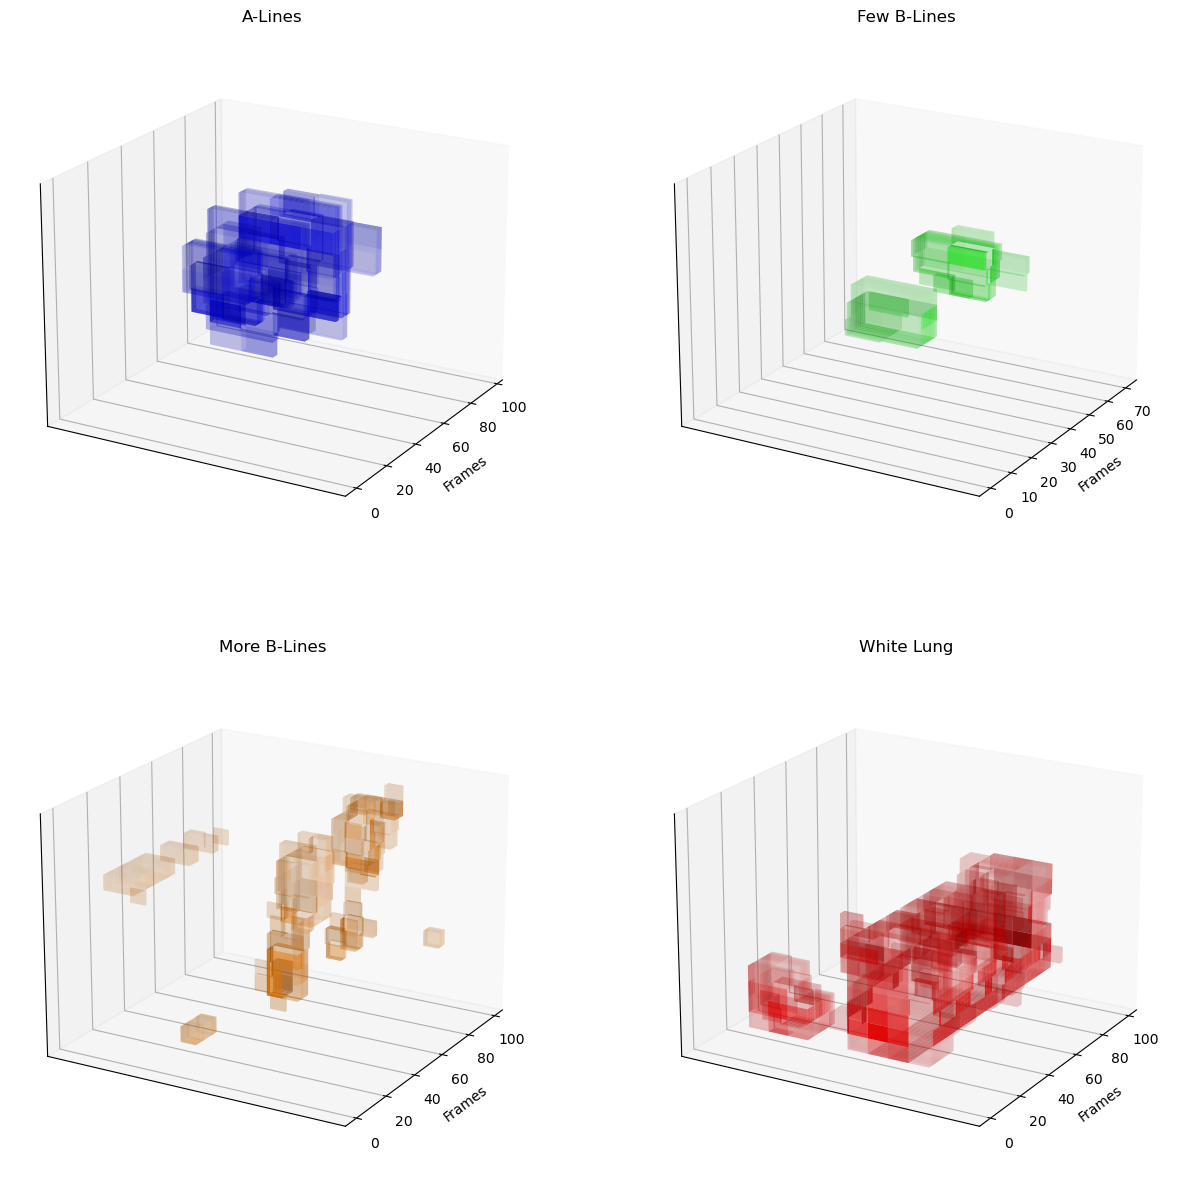

In [79]:
class_names = ["A-Lines", "Few B-Lines", "More B-Lines", "White Lung"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), subplot_kw=dict(projection='3d'))

for c, ax in zip(classes, axs.flat):
    volume = trimmed_filtered_frames[c]
    # Rotate the volume 90 around the x axis
    volume = np.rot90(volume, k=1, axes=(1, 2))
    # Scale volume to [0, 1]
    volume = (volume - volume.min()) / (volume.max() - volume.min())

    # Filled is a volume containing ones where the volume is not zero
    filled = np.ones(volume.shape)
    filled[volume <= 0.1] = 0

    # repeating values 3 times for grayscale
    colors = np.repeat(volume[:, :, :, np.newaxis], 3, axis=3)

    # Color class 1 blue, class 2 green, class 3 orange, class 4 red
    if c == 1:
        colors[:, :, :, 0] = 0
        colors[:, :, :, 1] = 0
        colors[:, :, :, 2] = 1
    elif c == 2:
        colors[:, :, :, 0] = 0
        colors[:, :, :, 1] = 1
        colors[:, :, :, 2] = 0
    elif c == 3:
        colors[:, :, :, 0] = 1
        colors[:, :, :, 1] = 0.5
        colors[:, :, :, 2] = 0
    elif c == 4:
        colors[:, :, :, 0] = 1
        colors[:, :, :, 1] = 0
        colors[:, :, :, 2] = 0

    # Add alpha channel with intensities proportional to the volume
    colors = np.concatenate((colors, volume[:, :, :, np.newaxis]), axis=3)

        
        

    ax.voxels(filled, facecolors=colors, edgecolors=None)
    # Remove the x and y ticks
    # ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # Name x axis 
    ax.set_xlabel("Frames")

    # Rotate the plot 90 around the z axis
    ax.view_init(20, 210)

    # Set title
    ax.set_title(f"{class_names[c-1]}")

plt.show()


In [74]:
colors.shape

(3, 97, 8, 10)

In [95]:
import plotly.graph_objects as go
import numpy as np
# Plotly volume rendering for the 4th class

volume = trimmed_filtered_frames[4]
# Scale volume to [0, 1]
volume = (volume - volume.min()) / (volume.max() - volume.min())

X, Y, Z = np.mgrid[0:volume.shape[0], 0:volume.shape[1], 0:volume.shape[2]]
values = volume.flatten()

fig = go.Figure(data=go.Volume(
    # Invert z axis
    x=Z.flatten(),
    y=X.flatten(),
    z=Y.flatten()*-1,
    value=values,
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ))
# Remove axis ticks
fig.update_layout(scene_xaxis_showticklabels=False,
                  scene_yaxis_showticklabels=False,
                  scene_zaxis_showticklabels=False)

# Rename y axis to "time"
fig.update_layout(scene = dict(
                    xaxis_title='X',
                    yaxis_title='Frames',
                    zaxis_title='Y'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

x_eye = -1.25
y_eye = 2.7
z_eye = 1

fig.update_layout(
        #  title='Class 4',
        #  width=600,
        #  height=600,
         scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
)

fig.show()

In [75]:
volume.shape

(99, 15, 13)

In [41]:
values.shape

(30, 30, 30)

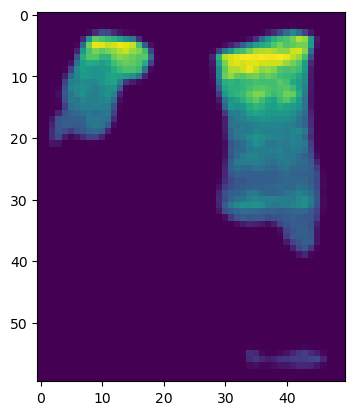

In [25]:
# Plot 4th class as image
plt.imshow(trimmed_filtered_frames[4][0])

In [20]:
# Get matplotlib version
import matplotlib
print(matplotlib.__version__)

3.6.1


In [254]:
class_4 = np.zeros((1,1,1))
class_4.shape

(1, 1, 1)

In [255]:
# Prepend empty dimensions to the volume to make it 4D
class_4 = class_4[np.newaxis, :, :, :]
class_4.shape

(1, 1, 1, 1)

In [256]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
class_4_cubical_persistence = cubical_persistence.fit_transform(class_4)

In [233]:
# Calculate the persistence diagrams for all classes
class__cubical_persistence = {}
cubical_persistence = CubicalPersistence(homology_dimensions=(0,1,2), n_jobs=-1)
for c in classes:
    class__cubical_persistence[c] = cubical_persistence.fit_transform(cropped_filtered_frames[c][np.newaxis, :, :, :])

# Save the persistence diagrams
import pickle
with open("class__cubical_persistence.pickle", "wb") as f:
    pickle.dump(class__cubical_persistence, f)

In [ ]:
# Load the persistence diagrams
import pickle
with open("class__cubical_persistence.pickle", "rb") as f:
    class__cubical_persistence = pickle.load(f)



In [ ]:

# Plot the persistence diagrams example
cubical_persistence.plot(class__cubical_persistence[1])


In [ ]:
# Plot the persistence diagrams for all classes using the cubical_persistence.plot() method
cubical_persistence.plot(class__cubical_persistence[1])

In [207]:
class_4_cubical_persistence.shape

(1, 326, 3)

In [258]:
class_4_cubical_persistence

array([[[0., 0., 0.],
        [0., 0., 1.]]])

In [257]:
cubical_persistence.plot(class_4_cubical_persistence)


In [211]:
# Compute Betti curves
from gtda.diagrams import BettiCurve

betti_curve = BettiCurve(n_jobs=-1)
class_4_betti_curves = betti_curve.fit_transform(class_4_cubical_persistence)

# Plot the Betti curves
betti_curve.plot(class_4_betti_curves)

In [212]:
class_4_betti_curves.shape

(1, 2, 100)

In [213]:
class_4_betti_curves.flatten().shape

(200,)

In [218]:
# Compute persistence images
from gtda.diagrams import PersistenceImage

persistence_image = PersistenceImage(n_bins=50, n_jobs=-1)
class_4_persistence_images = persistence_image.fit_transform(class_4_cubical_persistence)

# Plot the persistence images
persistence_image.plot(class_4_persistence_images, homology_dimension_idx = 1)

In [215]:
class_4_persistence_images.shape

(1, 2, 50, 50)

In [220]:
class_4_persistence_images.flatten().shape

(5000,)